In [30]:
import json
import numpy as np
from collections import defaultdict
from scipy.sparse import csr_matrix

In [31]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                        shape=loader['shape'])

In [32]:
with open('transmute_data.json') as f:
    data = json.load(f)
with open('sigma.json') as f:
    sigma = json.load(f)

In [33]:
nuc_idx = {n: i for i, n in enumerate(data['nucs'])}
N = len(nuc_idx)

In [34]:
decay_consts = {}
gammas = {}
for key, val in data['symbols'].items():
    if key.startswith('lambda'):
        _, n = key.split('_')
        decay_consts[n] = val
    elif key.startswith('gamma'):
        _, i, j, *_ = key.split('_')
        gammas[i, j] = val
    else:
        raise KeyError

In [35]:
def fix_gammas(gammas):
    """
    Make sure the gammas sum to 1. If there is a descrepancy, offset the biggest gamma
    """
    new_gammas = gammas.copy()
    for nuc in nuc_idx:
        gamma_sum = sum(gammas[(i, j)] for i, j in gammas if i == nuc)
        if gamma_sum in [0, 1]:
            continue
        print('gamma sum for', nuc, 'is', gamma_sum)
        biggest_gamma = max([(i, j) for i, j in gammas if i == nuc], key=lambda t: gammas[t])
        print("Offsetting biggest gamma", biggest_gamma, gammas[biggest_gamma], 'by', 1-gamma_sum)
        new_gammas[biggest_gamma] = gammas[biggest_gamma] + 1 - gamma_sum
        
    for nuc in nuc_idx:
        gamma_sum = sum(new_gammas[(i, j)] for i, j in gammas if i == nuc)
        assert gamma_sum in [0, 1], (nuc, gamma_sum)

    return new_gammas

In [36]:
gammas = fix_gammas(gammas)

gamma sum for U231 is 1.000055
Offsetting biggest gamma ('U231', 'Pa231') 1.0 by -5.499999999991623e-05
gamma sum for Zr89 is 1.000012
Offsetting biggest gamma ('Zr89', 'Y89M') 0.9984 by -1.1999999999900979e-05
gamma sum for Pu237 is 1.000033
Offsetting biggest gamma ('Pu237', 'Np237') 1.0 by -3.2999999999949736e-05
gamma sum for Am240 is 1.0000019
Offsetting biggest gamma ('Am240', 'Pu240') 1.0 by -1.8999999999991246e-06
gamma sum for Ba133M is 1.00001
Offsetting biggest gamma ('Ba133M', 'Ba133') 0.9999 by -1.0000000000065512e-05


In [37]:
sigma_ij = {(i, j): v for v, i, j in sigma.values() if v > 0.0 and j is not None}

In [38]:
phi = 4e14 * 1e-24  # flux, n / barn /s

In [39]:
dok = defaultdict(float) # indexed b y nuclide name
# let's first add the cross section channels
for i, j in sigma_ij:
    v = sigma_ij.get((i, j), 0.0) * phi
    dok[i, j] += v
    dok[i, i] -= v
# now let's add the decay consts
for (i, j), g in gammas.items():
    dok[i, j] += g * decay_consts[i]
for i, v in decay_consts.items():
    dok[i, i] -= v

In [40]:
len(dok)

3281

In [41]:
rows = []
cols = []
vals = []
for (i, j), v in dok.items():
    if (v == 0.0) or (i not in nuc_idx) or (j not in nuc_idx):
        continue
    rows.append(nuc_idx[i])
    cols.append(nuc_idx[j])
    vals.append(v)

In [42]:
mat = csr_matrix((vals, (rows, cols)), shape=(N, N))

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

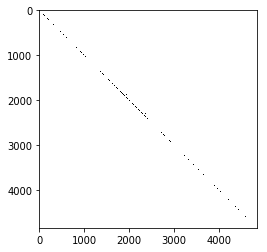

In [44]:
plt.imshow(mat.toarray() == 0.0, interpolation='none', cmap='gray')

In [45]:
save_sparse_csr('transmute.npz', mat)

In [46]:
lmat = load_sparse_csr('transmute.npz')

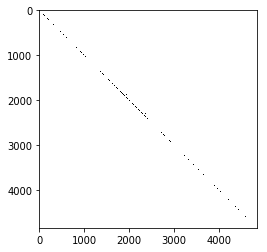

In [47]:
plt.imshow(lmat.toarray() == 0.0, interpolation='none', cmap='gray')

In [67]:
decay_consts['Np31']

KeyError: 'Np31'

In [18]:
nuc_idx['']

912

In [19]:
[i for i in nuc_idx if nuc_idx[i] == 10]

['He4']

In [20]:
decay_consts['He4']

0.0

In [21]:
[i for i in sigma_ij if 'He4' in i]

[('He3', 'He4')]

In [22]:
sigma_ij[('He3', 'He4')]

59.99

In [23]:
[i for i in nuc_idx if nuc_idx[i] == 868]

['Se89']

In [24]:
365.25/12 * 24 * 60 * 60

2629800.0

In [25]:
2.6e6

2600000.0

In [26]:
[i for i in nuc_idx if nuc_idx[i] == 1387]

['Pd111']

In [27]:
nuc_idx['Rh117']

1352

In [28]:
nuc_idx['Ru117']

1300

In [29]:
nuc_idx['Tc117']

1263

In [74]:
nuc_idx['Cf252']

4562

In [ ]:
nuc_idx['Mo117']

In [ ]:
[i for i in nuc_idx if nuc_idx[i] == 1594]

In [ ]:
nuc_idx['Pd118']

In [ ]:
[i for i in sigma_ij if 'Sn117' in i]

In [ ]:
sigma_ij[('Sn117', None)]

In [ ]:
data['channels']['Sn117']

In [77]:
[(i, sigma[i]) for i in sigma if 'Ho166' in sigma[i]]

[('sigma_alpha_Tm169', [7.809e-07, 'Tm169', 'Ho166'])]

In [42]:
nuc_idx['Co59M']

691

In [ ]:
nuc_idx['H1']

In [78]:
np.log(2)/decay_consts['U231']

362900.0

In [ ]:
[(i, sigma[i]) for i in sigma if "Ir180" in i]

In [ ]:
[i for i in sigma_ij if 'Ir180' in i]

In [96]:
[(i, gammas[i]) for i in gammas if 'Zr89' in i]

[(('Zr89', 'Y89M'), 0.9984), (('Zr89', 'Y89'), 0.001612)]

In [ ]:
np.log(2)/decay_consts['Cd117']/60/60

In [80]:
data['nucs'][4362]

'U231'

In [ ]:
for f in data['channels']:
    for type in data['channels'][f]:
        t = data['channels'][f][type]
        assert "sigma_" + type + "_" + t in sigma, (type, f)

In [ ]:
sigma['sigma_alpha_Ir180']

In [ ]:
data['channels']["Ir180"]

In [ ]:
np.exp(-0.77*phi*2.6e6)

In [ ]:
phi

In [ ]:
for i in sorted([(sum(v for (i, j), v in gammas.items() if i == f), f) for f in nuc_idx]):
    print(i)

In [40]:
dok[689,691]

0.0

In [88]:
for i in sorted([(sum(gammas[(i, j)] for i, j in gammas if i == nuc), nuc) for nuc in nuc_idx]):
    print(i)

(0, 'Ac206')
(0, 'Ac206M')
(0, 'Ac207')
(0, 'Ac208')
(0, 'Ac209')
(0, 'Ac210')
(0, 'Ac211')
(0, 'Ac212')
(0, 'Ac213')
(0, 'Ac214')
(0, 'Ac215')
(0, 'Ac216')
(0, 'Ac217')
(0, 'Ac217M')
(0, 'Ac218')
(0, 'Ac219')
(0, 'Ac220')
(0, 'Ac221')
(0, 'Ac222')
(0, 'Ac222M')
(0, 'Ac223')
(0, 'Ac224')
(0, 'Ac226')
(0, 'Ac226M')
(0, 'Ac228M')
(0, 'Ac229')
(0, 'Ac230')
(0, 'Ac231')
(0, 'Ac232')
(0, 'Ac233')
(0, 'Ac234')
(0, 'Ac235')
(0, 'Ac236')
(0, 'Ac237')
(0, 'Ag100')
(0, 'Ag100M')
(0, 'Ag101')
(0, 'Ag101M')
(0, 'Ag102')
(0, 'Ag102M')
(0, 'Ag103')
(0, 'Ag103M')
(0, 'Ag104')
(0, 'Ag104M')
(0, 'Ag105')
(0, 'Ag105M')
(0, 'Ag106M')
(0, 'Ag107')
(0, 'Ag107M')
(0, 'Ag109')
(0, 'Ag112M')
(0, 'Ag114M')
(0, 'Ag119M')
(0, 'Ag120M')
(0, 'Ag121M')
(0, 'Ag122M')
(0, 'Ag123M')
(0, 'Ag124M')
(0, 'Ag125M')
(0, 'Ag126M')
(0, 'Ag127M')
(0, 'Ag129')
(0, 'Ag129M')
(0, 'Ag130')
(0, 'Ag131')
(0, 'Ag132')
(0, 'Ag93')
(0, 'Ag93M')
(0, 'Ag94')
(0, 'Ag94M')
(0, 'Ag95')
(0, 'Ag96')
(0, 'Ag97')
(0, 'Ag98')
(0, 'Ag99')
(0, 'Ag

In [94]:
data['nucs'][4337]

'Pa235'